In [1]:
import numpy as np, os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [2]:
#GPU 사용 설정, -1이면 CPU 사용
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
#     tf.config.experimental.set_virtual_device_configuration(gpus[1], 
#                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Method1
일관성, 방향성 고려한 feature 탐지 <br>
**goal : 사망/생존 마커 탐지** <br>
- Score 계산 식

<div align=center> $Score = ReLU(FI^{inverse})*sign(FI^{reverse}) + Entropy$ </div>

- $FI^{reverse}$
  1. X_test의 각 feature의 값(4068개)을 모두 1로 바꾸어 예측
  2. 예측값 리스트의 평균값 계산
  3. 각 feature의 평균값과 기존 baseline의 평균값을 계산 (= x)
    - x = mean(pred) - mean(y_test)
  4. x > 0 이면 1, x <= 0 이면 -1 으로 {1, -1}으로 부호 결정
  
- `Entropy([proportion of 1, proportion of 0])`

# 필요한 데이터 로드

In [4]:
fi = pd.read_csv('./data/df_all_best_type.csv')
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())
model = tf.keras.models.load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

In [5]:
pre_list = fi[fi['Type']=='PRE'].feature.to_list()
lab_list = fi[fi['Type']=='LAB'].feature.to_list()
pro_list = fi[fi['Type']=='PRO'].feature.to_list()

def what_type(x):
    if x in pre_list:
        return 'PRE'
    elif x in lab_list:
        return 'LAB'
    elif x in pro_list:
        return 'PRO'
    else:
        return 'ERROR'

In [6]:
#all train으로 기존 method1 계산 결과
result_df = pd.read_csv('./data/method1_all_train_score.csv').sort_values('feature').reset_index(drop=True)
result_df

,feature,score
0,0,-0.000000
1,50803,-0.002118
2,50804,0.003495
3,50805,-0.001575
4,50806,0.005405
...,...,...
4063,78112001103,-0.002014
4064,79511050204,-0.000000
4065,87701071218,0.013409
4066,87701083336,-0.000000


# 각 feature별 Entropy 계산
`Entropy([proportion of 1, proportion of 0])`

In [7]:
def entropy(ratio_list):
    one_ratio, zero_ratio = ratio_list[0], ratio_list[1] 
    return - ((one_ratio * (np.log2(one_ratio))) + (zero_ratio * (np.log2(zero_ratio))))

In [8]:
a = 0.9965187006600233
b = 1 - a
entropy([a,b])

0.03344254269947627

In [9]:
X = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

result = []
for i in tqdm(range(len(COLS))):
    one_ratio = X[:,:,i].sum() / (X.shape[0]*X.shape[1])
    zero_ratio = 1 - one_ratio
    entropy_num = entropy([one_ratio, zero_ratio])
    result.append({'feature' : i, 'entropy' : entropy_num})

  0%|          | 0/4068 [00:00<?, ?it/s]

In [10]:
entropy_df = pd.DataFrame(result).fillna(0)

In [16]:
result_df['entropy'] = entropy_df['entropy']
result_df['add_entropy'] = result_df['score'] * entropy_df['entropy']
result_df['Type'] = result_df['feature'].apply(lambda x:what_type(x))

In [17]:
result_df = result_df.sort_values('add_entropy', ascending=False)
result_df

,feature,score,entropy,add_entropy,Type
2148,409176230,0.014189,0.380630,0.005401,PRE
119,51003,0.014328,0.329998,0.004728,LAB
2291,487980125,0.007584,0.609046,0.004619,PRE
20,50862,0.007828,0.470553,0.003684,LAB
8,50813,0.011908,0.302050,0.003597,LAB
...,...,...,...,...,...
1034,56017275,-0.011329,0.188707,-0.002138,PRE
383,227194,-0.025418,0.084824,-0.002156,PRO
307,224277,-0.006929,0.315556,-0.002187,PRO
19,50861,-0.008277,0.400005,-0.003311,LAB


# Visualization

In [14]:
X = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
# 컬럼이름 로드
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

#death_index
d_index = np.where(y==1)[0]
#survive_index (퇴원 환자)
s_index = np.where(y==0)[0]

#사망/퇴원 환자 분리
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []
#day - 10일
for d in range(10):
    #4068 - ITEM
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

def visualization(top10_list):
    plt.figure(figsize = (13,12), dpi=150)
    for i, f in enumerate(top10_list):
        plt.subplot(4,3,1+i)
        plt.title(f)
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='사망')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='퇴원')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
    plt.tight_layout()

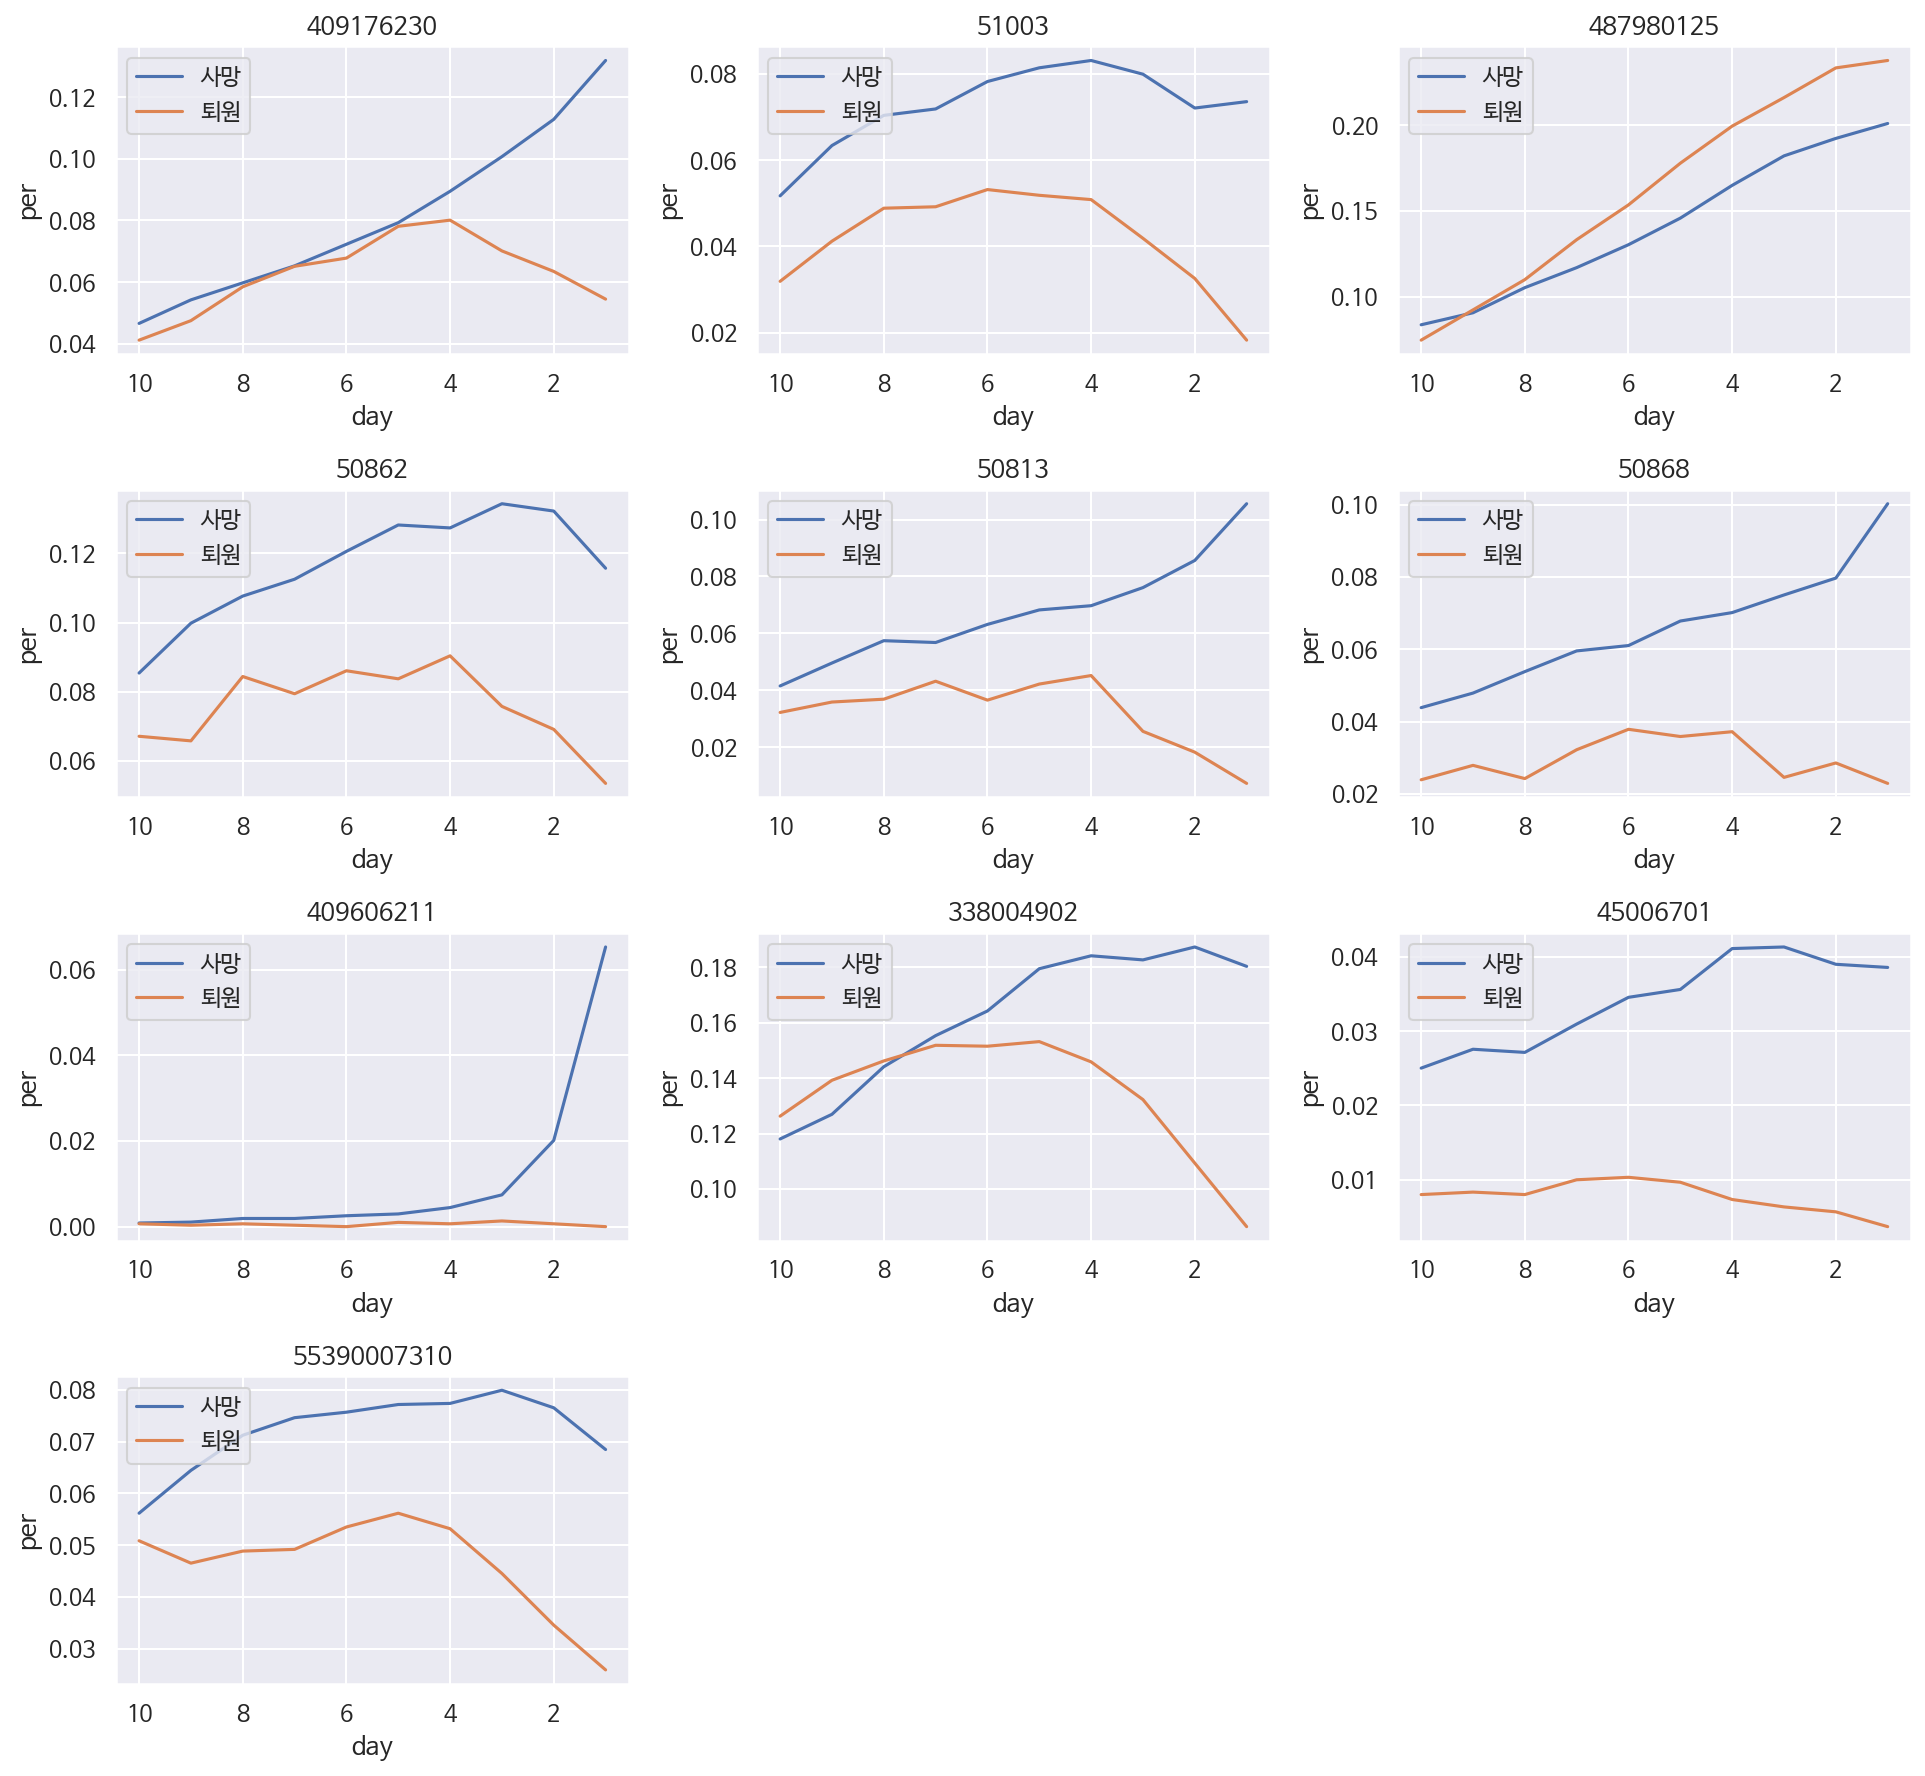

In [15]:
visualization(result_df.feature[:10].to_list())